# Returns Supply Chain Analytics – Consumer Electronics
#This notebook walks through data cleaning, exploratory data analysis (EDA), demand forecasting, and scenario-based simulation to optimize return logistics for a consumer electronics business.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

import sys
import os
sys.path.append('../scripts')

import data_loader
from forecasting_models import run_forecasting_engine_powerbi
from simulation_engine import run_simulation_engine
sns.set(style='whitegrid')
print("✅ All modules imported successfully!")

✅ All modules imported successfully!


Data Loading

In [42]:
df = pd.read_csv('../data/data.csv')  # path relative to notebooks/
df.head()


,SKU,Order_Date,Product_Type,Price,Availability,Number_Products_Sold,Revenue_Generated,Customer_Region,Customer_Segment,Supplier_Name,...,Return_Reason,Return_Date,Refund_Status,Shipping_Carrier,Shipping_Cost,Transport_Mode,Lead_Time,Manufacturing_Lead_Time,Shipping_Time,Notes
0,SKU10000,2024-09-09 21:29:37.847990,Laptop,1356.60,In Stock,16,21705.60,West,Regular,Supplier_A,...,NaN,NaN,NaN,Carrier_X,72.74,Ground,41,8,3,NaN
1,SKU10001,2025-03-04 21:29:37.847990,Smartphone,658.94,In Stock,32,21086.08,North,Regular,Supplier_B,...,NaN,NaN,NaN,Carrier_X,58.75,Air,12,4,2,NaN
2,SKU10002,2025-01-16 21:29:37.847990,Laptop,965.52,In Stock,8,7724.16,West,Regular,Supplier_D,...,NaN,NaN,NaN,Carrier_Z,73.30,Air,29,7,1,NaN
3,SKU10003,2024-10-09 21:29:37.847990,Smartwatch,600.00,In Stock,19,11400.00,East,Wholesale,Supplier_D,...,Defective,2024-10-27 21:29:37.847990,Pending,Carrier_X,22.52,Ground,32,9,4,NaN
4,SKU10004,2025-01-07 21:29:37.847990,Smartphone,568.92,In Stock,19,10809.48,Central,Regular,Supplier_D,...,NaN,NaN,NaN,Carrier_Y,25.49,Ground,33,6,9,NaN


4. Data Preprocessing

In [43]:
# Check nulls, types
df.info()
df.isnull().sum()

# Fix date columns
df['Return_Date'] = pd.to_datetime(df['Return_Date'])

# Fill missing values or drop if necessary
df['Lead_Time'].fillna(df['Lead_Time'].median(), inplace=True)

# Create useful features
df['Return_Week'] = df['Return_Date'].dt.isocalendar().week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SKU                      15000 non-null  object 
 1   Order_Date               15000 non-null  object 
 2   Product_Type             15000 non-null  object 
 3   Price                    15000 non-null  float64
 4   Availability             15000 non-null  object 
 5   Number_Products_Sold     15000 non-null  int64  
 6   Revenue_Generated        15000 non-null  float64
 7   Customer_Region          15000 non-null  object 
 8   Customer_Segment         15000 non-null  object 
 9   Supplier_Name            15000 non-null  object 
 10  Supplier_Defect_Rate     15000 non-null  float64
 11  Inspection_Result        13159 non-null  object 
 12  Defect_Rate              15000 non-null  float64
 13  Return_Reason            2425 non-null   object 
 14  Return_Date           

In [44]:
df['Product_Type'].unique()

array(['Laptop', 'Smartphone', 'Smartwatch', 'Headphones', 'Tablet'],
      dtype=object)

In [45]:
revenue_by_product = df.groupby('Product_Type')['Revenue_Generated'].sum()
units_sold = df.groupby('Product_Type')['Number_Products_Sold'].sum()
ship=df.groupby('Shipping_Carrier')['Revenue_Generated'].sum().reset_index()
revenue_per_unit = revenue_by_product / units_sold
avg_revenue_per_unit = df.groupby('Product_Type').apply(
    lambda x: x['Revenue_Generated'].sum() / x['Number_Products_Sold'].sum()
)


summary = pd.DataFrame({
    'Total_Revenue': revenue_by_product,
    'Total_Units_Sold': units_sold,
    'Avg_Revenue_Per_Unit': avg_revenue_per_unit
}).reset_index() 

 Exploratory Data Analysis (EDA)

Total sales volume and revenue generated by product type
understand which product categories should be proioritized for inventory and supply chain focus.

In [46]:

fig = px.bar(summary, 
             x='Product_Type', 
             y='Total_Revenue', 
             title='Total Revenue by Product Type',
             text='Total_Revenue')

fig.show()



#The company generates most revenue by smartphones 
#followed by laptops having nearly similair revenue range


In [47]:
pie_chart=px.pie(units_sold,
                 values='Number_Products_Sold',
                 names=units_sold.index,
                 title='Units Sold by Product Type',
                 hole=0.5,
                 color_discrete_sequence=px.colors.qualitative.Pastel)
pie_chart.update_traces(textposition='inside', textinfo='percent+label')
pie_chart.show()

46.5% of the business comes from smartphone,26.5% from laptops 11.9 from headphones,7.72 from smartwatches and 7.12 from tablets 

In [48]:
print(revenue_per_unit)

Product_Type
Headphones     186.089879
Laptop        1341.696031
Smartphone     823.560975
Smartwatch     390.136287
Tablet         574.684789
dtype: float64


laptops generate the most revenue per unit 

In [49]:
fig=go.Figure()
fig.add_trace(go.Bar(x=ship['Shipping_Carrier'],
                     y=ship['Revenue_Generated']))
fig.update_layout(title='Total Revenue by Shipping Carrier',
                  xaxis_title='Shipping Carrier',
                  yaxis_title='Revenue Generated')
fig.show()

so the company is using 4 carriers for transportation, carrier X helps the company in generating more revenue closely followed by Y.

Bar Plot: Return Rate by Product Type
To identify which products were returned more. helps prioritieze quality cheks redesign or vendor changes.

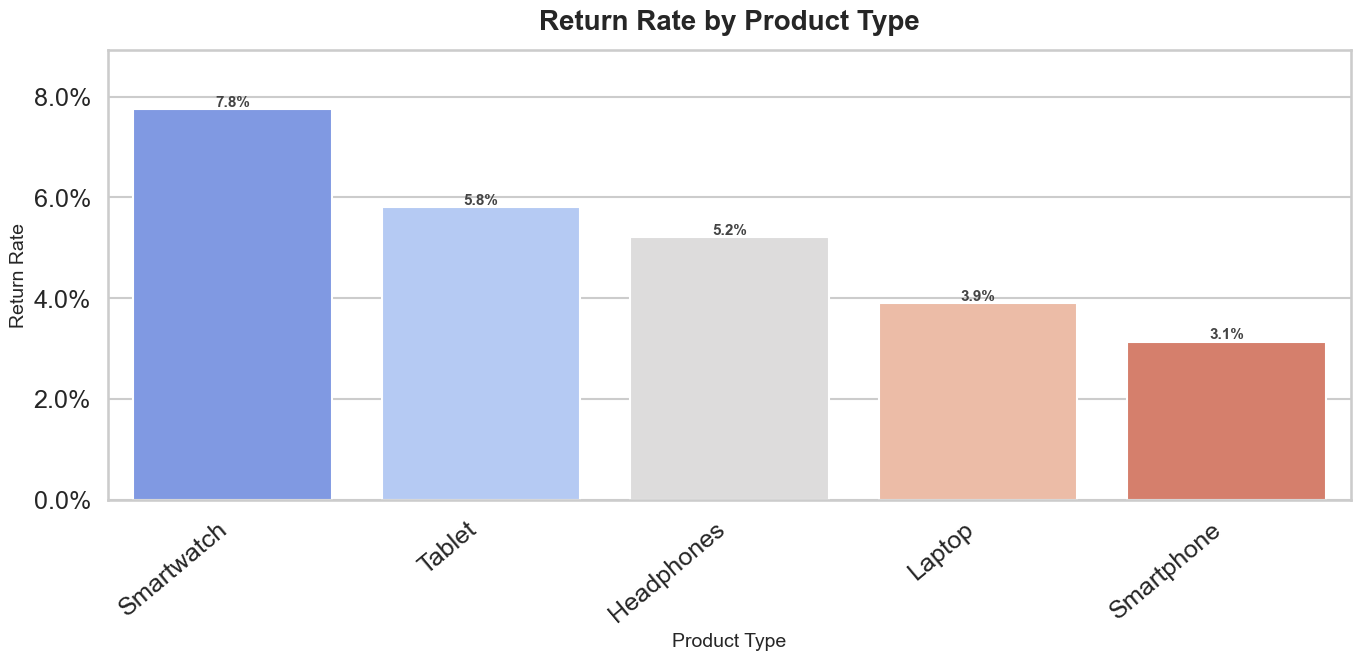

In [50]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

return_counts = df['Product_Type'].value_counts()
total_sales = df.groupby('Product_Type')['Number_Products_Sold'].sum()
return_rate = (return_counts / total_sales).sort_values(ascending=False)


plt.figure(figsize=(14,7))
palette = sns.color_palette("coolwarm", len(return_rate))

bars = sns.barplot(x=return_rate.index, y=return_rate.values, palette=palette)

# Add percentage labels on bars
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.1%}', 
                  (bar.get_x() + bar.get_width() / 2, height), 
                  ha='center', va='bottom', fontsize=11, fontweight='bold', color='#444')

plt.title('Return Rate by Product Type', fontsize=20, fontweight='bold', pad=15)
plt.ylabel('Return Rate', fontsize=14)
plt.xlabel('Product Type', fontsize=14)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(rotation=40, ha='right')
plt.ylim(0, max(return_rate.values)*1.15)
plt.tight_layout()
plt.show()

smartwatches are the most returned product 
company needs to make sure to find why are the smartwatches returned more often.

What is the return rate by Product_Type and by Return_Reason?
: Identify product categories and common issues causing returns, essential for quality control and supplier evaluation.

In [51]:
returned_units = df[df['Return_Reason'].notnull()].groupby(['Product_Type', 'Return_Reason'])['Number_Products_Sold'].sum()
return_rate_reason= (returned_units/total_sales).sort_values(ascending=False)
print(return_rate_reason)


Product_Type  Return_Reason
Tablet        Defective        0.051132
Smartwatch    Defective        0.050689
Headphones    Late Delivery    0.047991
Laptop        Defective        0.046133
Headphones    Defective        0.046071
Smartphone    Defective        0.044529
Laptop        Late Delivery    0.044422
Tablet        Changed Mind     0.040255
Smartphone    Late Delivery    0.039111
Laptop        Changed Mind     0.036348
Smartwatch    Changed Mind     0.036089
Tablet        Late Delivery    0.035882
Smartphone    Changed Mind     0.033693
Smartwatch    Late Delivery    0.030842
              Other            0.029985
Headphones    Changed Mind     0.029063
Tablet        Other            0.026243
Headphones    Other            0.023348
Smartphone    Other            0.023218
Laptop        Other            0.022118
Tablet        Wrong Product    0.020399
Smartwatch    Wrong Product    0.019455
Headphones    Wrong Product    0.017378
Laptop        Wrong Product    0.014797
Smartphone  

 Correlation Matrix: Numeric Supply Chain Features (relationships between numeric features in supply chain like leadtime,cost defect rate and sales)

 A correlation matrix helps uncover hidden patterns between metrics. For example:
Does higher Lead_Time correlate with increased Defect_Rate?
Is Revenue_Generated mainly driven by Number_Products_Sold, or is Price playing a bigger role?
Do shipping costs relate to time taken or defect rates?

These insights guide process improvement—like whether to renegotiate shipping terms or investigate suppliers with high defect correlations.



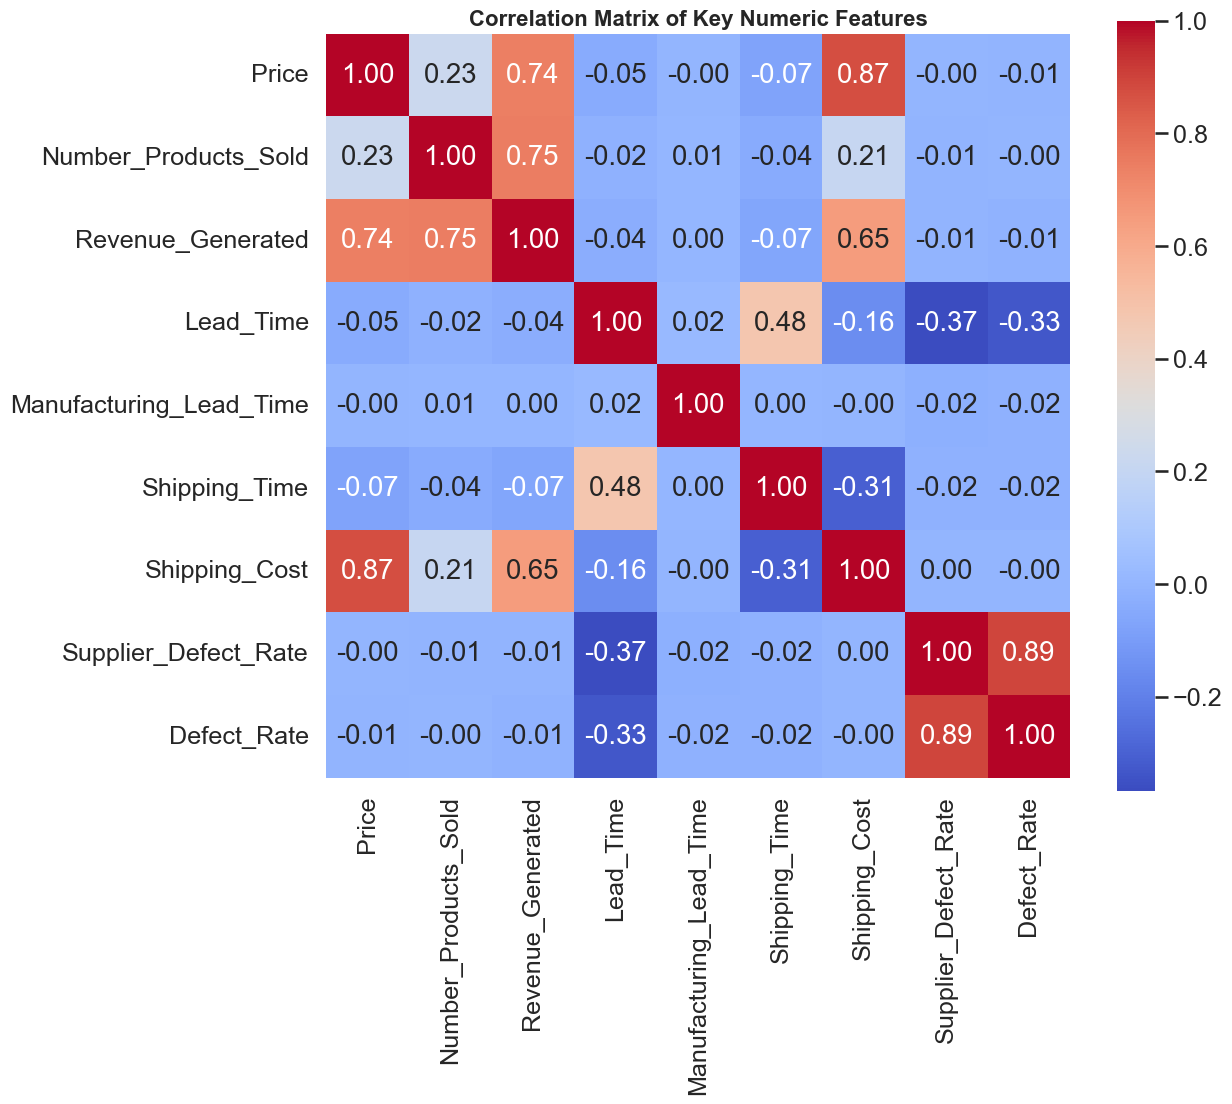

In [52]:
numeric_cols = [
    'Price',
    'Number_Products_Sold',
    'Revenue_Generated',
    'Lead_Time',
    'Manufacturing_Lead_Time',
    'Shipping_Time',
    'Shipping_Cost',
    'Supplier_Defect_Rate',
    'Defect_Rate'
]

# Compute correlation matrix on the filtered columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Key Numeric Features', fontsize=16, fontweight='bold')
plt.show()

* Price and Revenue_Generated (0.74): There's a strong positive correlation between the price of a product and the revenue generated. This is intuitive, as higher prices generally lead to higher revenue, assuming demand doesn't drop significantly.
* Price and Shipping_Cost (0.87): A very strong positive correlation exists between Price and Shipping_Cost. This suggests that more expensive products tend to have higher shipping costs, possibly due to size, weight, or special handling requirements.
* There's a very strong positive correlation between the supplier's defect rate and the overall defect rate. This indicates that the quality of products from suppliers significantly impacts the final defect rate of the goods.

* Lead_Time and Defect_Rate (-0.33): There's a moderate negative correlation between Lead_Time and Defect_Rate. This could imply that longer lead times (perhaps indicating more thorough checks or better planning) might be associated with a slightly lower defect rate.


Checking a relationship between the return rate and lead times:
checking weather is delay in delivering products somehow causing returns.

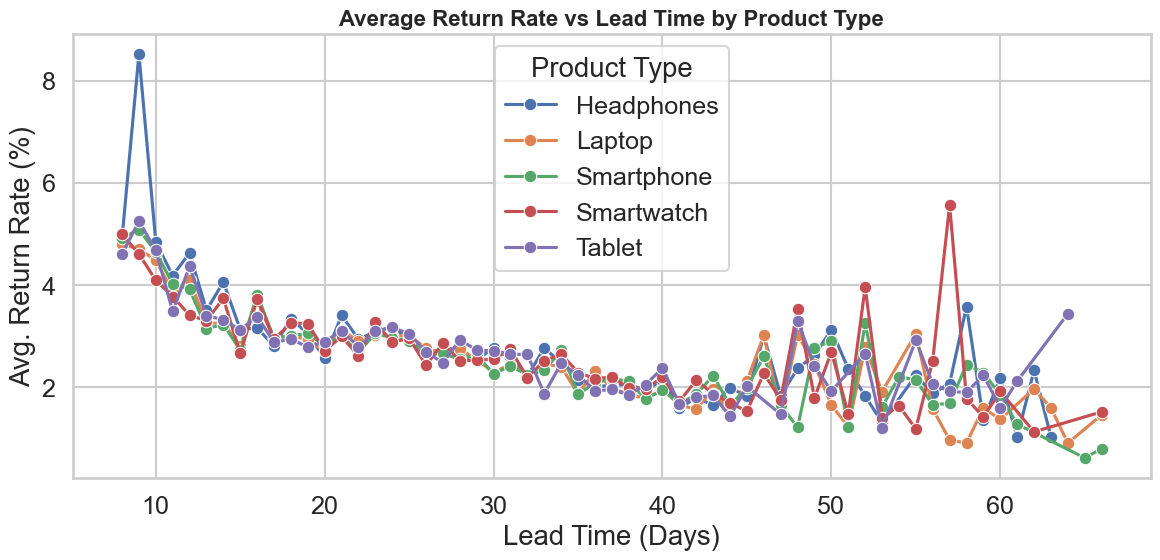

In [53]:
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")

# Group and compute mean defect rate per lead time per product type
grouped = df.groupby(['Lead_Time', 'Product_Type'])['Defect_Rate'].mean().reset_index()

sns.lineplot(data=grouped, x='Lead_Time', y='Defect_Rate', hue='Product_Type', marker='o')

plt.title("Average Return Rate vs Lead Time by Product Type", fontsize=16, weight='bold')
plt.xlabel("Lead Time (Days)")
plt.ylabel("Avg. Return Rate (%)")
plt.legend(title='Product Type')
plt.tight_layout()
plt.show()


General Trend: Decreasing Return Rate with Increasing Lead Time (Initially):

For most product types, there's a clear trend in the initial phase (approximately up to 30-35 days lead time) where the average return rate tends to decrease as the lead time increases.
This suggests that very short lead times (e.g., under 15 days) are often associated with higher return rates. This could be due to rushed processing, inadequate quality checks, or customers receiving items sooner than expected and having more time to change their minds or find issues.
Volatile Return Rates at Shorter Lead Times (5-15 Days):

The return rates are significantly more volatile and generally higher for lead times between approximately 5 and 15 days.
Headphones (around 8-10 days): Headphones show a particularly high peak in return rate (over 8%) around a 9-day lead time, significantly higher than other product types at similar lead times. This is a notable outlier.
Other products also show elevated return rates in this initial period, though not as extreme as Headphones.



Stabilization and Lower Return Rates in Mid-Range Lead Times (approx. 25-45 Days):
As lead time extends from roughly 25 to 45 days, the average return rates for all product types tend to stabilize at a lower level, generally hovering between 2% and 3%. This indicates that there might be an "optimal" lead time window where return rates are more consistent and lower.


Increased Volatility and Fluctuations at Longer Lead Times (beyond 45 Days):
Beyond approximately 45 days of lead time, the return rates for several product types begin to show increased volatility and sporadic peaks.
Smartwatch: Shows a significant spike in return rate (over 5.5%) around 57-58 days of lead time.
Smartphone and Tablet: Also exhibit noticeable fluctuations and occasional increases in return rates at these longer lead times.
This could be due to smaller sample sizes for very long lead times, or perhaps indicate that excessively long lead times lead to customer frustration, change of mind, or the product no longer being needed upon arrival.


Product-Specific Behaviors:
Headphones: Stands out with its exceptionally high return rate at very short lead times (around 9 days). This suggests a potential issue specific to headphones with very quick delivery.
Laptops: Generally appear to maintain relatively lower and more stable return rates across various lead times compared to some other categories, especially at longer lead times where others fluctuate more.
Smartwatch: Exhibits a particularly high peak in return rate at longer lead times (around 57-58 days), warranting further investigation.

Analysing SKUs
So, SKU stands for Stock Keeping Units. They’re like special codes that help companies keep track of all the different things they have for sale. Imagine you have a large toy store with lots of toys. Each toy is different and has its name and price, but when you want to know how many you have left, you need a way to identify them. So you give each toy a unique code, like a secret number only the store knows. This secret number is called SKU.

In [54]:
sku_revenue = df.groupby('SKU')['Revenue_Generated'].sum().sort_values(ascending=False).head(20)

fig = px.bar(sku_revenue.reset_index(),
             x='SKU', y='Revenue_Generated',
             title='Top 20 SKUs by Revenue')
fig.show()


Stock levels by sku

In [55]:
sku_summary=df.groupby('SKU').agg({
    'Availability': 'sum',
    'Number_Products_Sold': 'sum',
}).reset_index()
sku_summary.columns = ['SKU', 'Total_Stock', 'Total_Sold']
print(sku_summary.head())


        SKU Total_Stock  Total_Sold
0  SKU10000    In Stock          16
1  SKU10001    In Stock          32
2  SKU10002    In Stock           8
3  SKU10003    In Stock          19
4  SKU10004    In Stock          19


top 20 sku by orders and stock

In [56]:
total_sku= sku_summary.nlargest(20,'Total_Sold')
melted = total_sku.melt(id_vars='SKU', 
                         value_vars=['Total_Stock', 'Total_Sold'], 
                         var_name='Metric', 
                         value_name='Value')




fig = px.bar(melted,
             x='SKU', 
             y='Value', 
             color='Metric', 
             barmode='group',
             title='Top 20 SKUs: Stock vs Units Sold')

fig.show()


Shipping cost by carriers

In [57]:
shipping_cost_by_carrier = df.groupby('Shipping_Carrier')['Shipping_Cost'].sum().reset_index()
shippping_cost_chart=px.bar(shipping_cost_by_carrier,x='Shipping_Carrier',
                     y='Shipping_Cost',
                     title='Total Shipping Cost by Carrier',
                     color='Shipping_Carrier')
shippping_cost_chart.show()

Carrier X has highest shipping cost of 223.7362k
also as it generates most revenue too

How does the Defect_Rate vary across Product_Type, Supplier_Name, and Inspection_Result?
Pinpoint quality problems linked to suppliers or inspection stages to improve supplier management and inspection processes.

In [58]:
if all(col in df.columns for col in ['Product_Type', 'Return_Reason', 'Number_Products_Sold']):
    returns=df[df['Return_Reason'].notnull()]
    if not returns.empty:
        return_units=returns.groupby(['Product_Type', 'Return_Reason'])['Number_Products_Sold'].sum()

In [59]:
grouped_data = returns.groupby(['Product_Type', 'Return_Reason']).size().reset_index(name='Return_Count')

fig = px.bar(
    grouped_data,
    x='Product_Type',
    y='Return_Count',
    color='Return_Reason',
    barmode='group',
    title='Return Reasons by Product Type (Grouped)'
)
fig.show()


majority reason for returning is the defective product being provided to customers.
more product like headphones and laptops late delivery are also major reasons for return.

How does the Defect_Rate vary across Product_Type, Supplier_Name, and Inspection_Result?

Pinpoint quality problems linked to suppliers or inspection stages to improve supplier management and inspection processes.



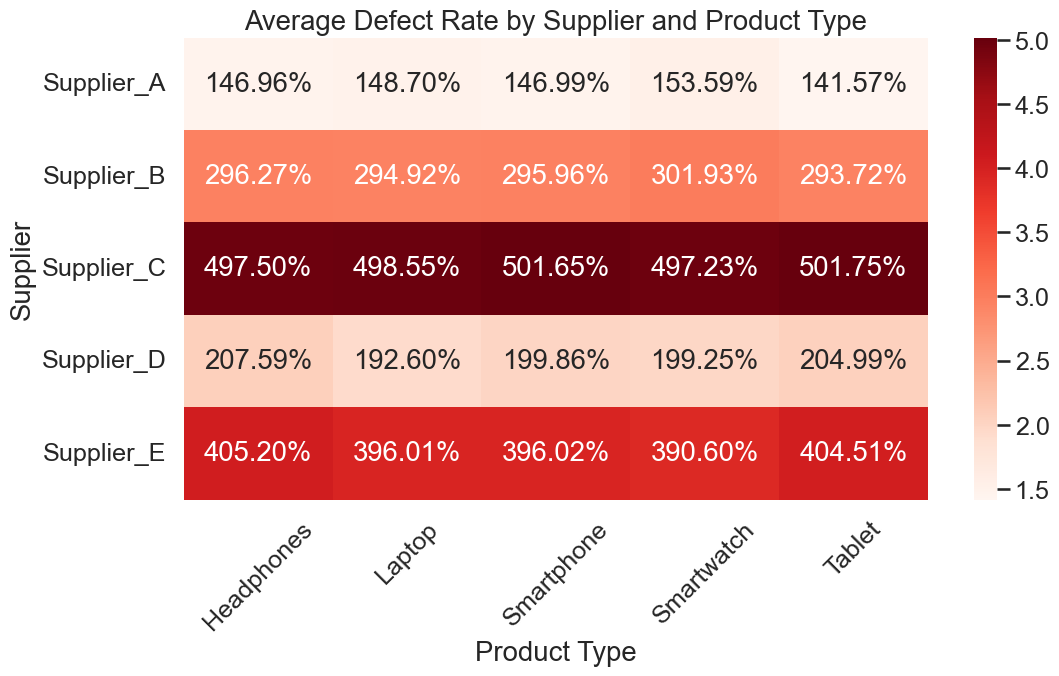

In [60]:

heat_df = df.groupby(['Supplier_Name', 'Product_Type'])['Defect_Rate'].mean().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(heat_df, annot=True, cmap="Reds", fmt=".2%")
plt.title("Average Defect Rate by Supplier and Product Type")
plt.xlabel("Product Type")
plt.ylabel("Supplier")
plt.xticks(rotation=45)
plt.show()

Significant Variation in Defect Rates Across Suppliers:
There's a dramatic difference in average defect rates among the suppliers.
Supplier_A consistently has the lowest defect rates, generally in the range of 140-150%.
Supplier_B has moderate defect rates, consistently in the range of 290-300%.
Supplier_D also falls into the moderate range, with defect rates around 190-200%.
Supplier_C and Supplier_E exhibit exceptionally high defect rates, consistently in the range of 400-500%. These are alarmingly high figures.


Supplier Performance Dominates Product Type Impact:
For a given supplier, the defect rate remains relatively consistent across different product types. This suggests that the supplier's overall quality control and manufacturing processes are a far more significant determinant of the defect rate than the specific product type being manufactured.
For example, Supplier_C's defect rates for Headphones, Laptop, Smartphone, Smartwatch, and Tablet are all very close (around 497-501%). The same consistency is observed for all other suppliers across their respective product ranges.


Identification of Best and Worst Performers:
Best Performer: Supplier_A is clearly the best-performing supplier in terms of defect rates across all product types.
Worst Performers: Supplier_C and Supplier_E are the worst-performing suppliers, with defect rates that are several times higher than those of Supplier_A.


No Strong Product Type Specific Trends (within a supplier):
While there are minor variations (e.g., Supplier_A's highest rate is for Smartwatch at 153.59%, and lowest for Tablet at 141.57%), these differences are marginal when compared to the vast differences between suppliers. This reinforces the point that supplier quality is the primary driver.

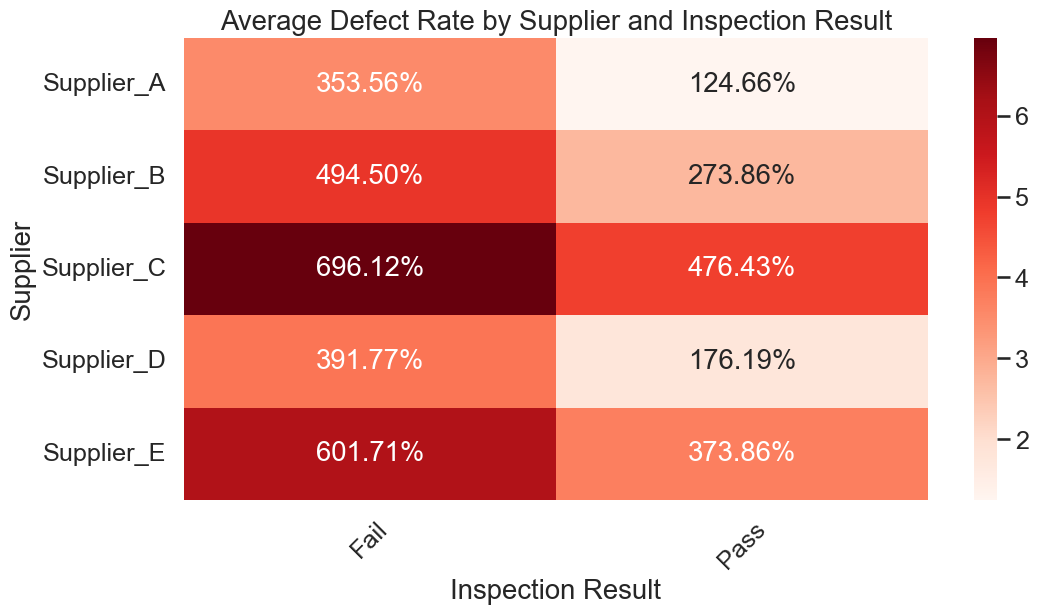

In [61]:

heat_df = df.groupby(['Supplier_Name', 'Inspection_Result'])['Defect_Rate'].mean().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(heat_df, annot=True, cmap="Reds", fmt=".2%")
plt.title("Average Defect Rate by Supplier and Inspection Result")
plt.xlabel("Inspection Result")
plt.ylabel("Supplier")
plt.xticks(rotation=45)
plt.show()

"Fail" Inspection Results Show Significantly Higher Defect Rates:

Across all suppliers, products that received a "Fail" inspection result consistently have substantially higher average defect rates compared to those that "Pass."
For instance, Supplier_A's defect rate is 353.56% for "Fail" but 124.66% for "Pass." This pattern holds true for every supplier.


Wide Variation in Defect Rates Among Suppliers for Both Outcomes:
Similar to the previous analysis, there's a considerable difference in defect rates between suppliers for both "Fail" and "Pass" inspection results.
Supplier_A consistently has the lowest defect rates, whether the inspection result is "Fail" (353.56%) or "Pass" (124.66%). This reinforces its position as the best-performing supplier in terms of defect control.
Supplier_C shows the highest defect rates for both "Fail" (696.12%) and "Pass" (476.43%) categories. This indicates severe quality issues across the board for this supplier, even for items that ostensibly "Pass" inspection.
Supplier_B, Supplier_D, and Supplier_E fall in between, with Supplier_E (601.71% for Fail, 373.86% for Pass) and Supplier_B (494.50% for Fail, 273.86% for Pass) generally performing worse than Supplier_D (391.77% for Fail, 176.19% for Pass).


"Pass" Doesn't Mean Zero Defects, or Even Low Defects:
Critically, even for items that "Pass" inspection, the defect rates are alarmingly high (ranging from 124.66% for Supplier_A to 476.43% for Supplier_C).
A defect rate exceeding 100% implies that, on average, there is more than one defect per item. This suggests that the "Pass" inspection criteria might be too lenient, or the inspection process itself is not effective at catching all defects. It could also indicate that the "defect rate" metric is calculated in a way that allows for multiple defects per item, leading to percentages over 100%.

What are the monthly or quarterly trends for sales, returns, and defects (Number_Products_Sold, Return_Date, Defect_Rate)?
Detect seasonal demand changes and return patterns for better capacity planning.

In [62]:
df['Order_Month']=pd.to_datetime(df['Order_Date']).dt.to_period('M')
df['Return_Month']=pd.to_datetime(df['Return_Date']).dt.to_period('M')


In [63]:
monthly_sales = df.groupby('Order_Month').agg({
    'Number_Products_Sold': 'sum',
    'Defect_Rate': 'mean',
}).reset_index()
monthly_returns = df[df['Return_Date'].notnull()].groupby('Return_Month').size().reset_index(name='Returns')

monthly_sales['Order_Month'] = monthly_sales['Order_Month'].dt.to_timestamp()
monthly_returns['Return_Month'] = monthly_returns['Return_Month'].dt.to_timestamp()

In [64]:


fig_main = go.Figure()


fig_main.add_trace(go.Scatter(
    x=monthly_sales['Order_Month'],
    y=monthly_sales['Number_Products_Sold'],
    mode='lines+markers',
    name='Sales'
))


fig_main.add_trace(go.Scatter(
    x=monthly_sales['Order_Month'],
    y=monthly_sales['Defect_Rate'] * 100,
    mode='lines+markers',
    name='Defect Rate (%)',
    yaxis='y2'
))

fig_main.update_layout(
    title='📊 Monthly Sales & Defect Rate',
    xaxis_title='Month',
    yaxis=dict(title='Units Sold', rangemode='tozero'),
    yaxis2=dict(
        title='Defect Rate (%)',
        overlaying='y',
        side='right',
        showgrid=False,
        rangemode='tozero'
    ),
    legend=dict(x=0, y=0)
)

fig_main.show()


fig_returns = go.Figure()

fig_returns.add_trace(go.Scatter(
    x=monthly_returns['Return_Month'],
    y=monthly_returns['Returns'],
    mode='lines+markers',
    name='Returns',
    line=dict(color='crimson')   
))

fig_returns.update_layout(
    title='📉 Monthly Returns',
    xaxis_title='Month',
    yaxis_title='Units Returned',
    yaxis=dict(rangemode='tozero'),
    showlegend=False
)

fig_returns.show()



Sales:
    start low in May around 2500 units then drastic increase to 34000 by june 2024
    lowesr point in the declining phase is around 21000 units in Feb 2025
    sales recover somewhat by March 2025(around 30,000) but then decline again approximately 25000 units by May 2025
Defect Rate:
    very high level in May 2024 around 270 %
    then drops significanlty to 260% in june 2024
    defect rate remains relatively stable between 250 and 270%


Relationship Between Sales and Defect Rate:
Initial Phase (May-June 2024): A sharp increase in sales coincided with a noticeable decrease in the defect rate. This is a positive sign, suggesting that scaling up operations initially led to better quality control.
Subsequent Period: For the remainder of the period, there doesn't appear to be a strong inverse or direct correlation between the two. Sales fluctuate, but the defect rate largely remains within a consistent, albeit high, range. This indicates that sales volume changes do not consistently drive the defect rate up or down after the initial ramp-up.


Monthly Returns:


Initial Returns Surge:
Returns start at zero in May 2024, mirroring the very low sales in that month.
There's a sharp increase in returns from June 2024 (around 120 units) to July 2024 (over 200 units). This surge in returns directly follows the major sales increase observed in June 2024 in the previous chart.
Returns Stabilization and Fluctuations:

After the initial surge, returns stabilize and fluctuate around 180-220 units for most of the period, from July 2024 to March 2025.
There's a peak in November 2024 (around 215 units) and another peak in March 2025 (around 210 units).
Recent Drop in Returns:

A significant drop in returns is observed from April 2025 (around 195 units) to May 2025 (around 70 units).

In [65]:
monthly_returns = df[df['Return_Date'].notnull()].groupby('Return_Month').size().reset_index(name='Returns')
monthly_returns['Return_Month'] = monthly_returns['Return_Month'].dt.to_timestamp()
monthly_returns

,Return_Month,Returns
0,2024-05-01,1
1,2024-06-01,118
2,2024-07-01,210
3,2024-08-01,215
4,2024-09-01,211
5,2024-10-01,205
6,2024-11-01,185
7,2024-12-01,216
8,2025-01-01,195
9,2025-02-01,199


Customer Segmentation analysis
Revenue, returns, and defect rates by Customer_Segment and Customer_Region
Which regions should be prioritised for customer benefits

In [66]:
grouped=df.groupby(['Customer_Segment', 'Customer_Region']).agg({
    'Revenue_Generated': 'sum',
    'Defect_Rate': 'mean',
    'Return_Reason': 'count'
}).reset_index()

In [67]:
fig1=px.bar(grouped,x='Customer_Segment',
            y='Revenue_Generated',
            color='Customer_Region',
            barmode='group',
            title='Revenue by Customer Segment and Region')
fig1.show()

Returns by Segment and Region

In [68]:
fig2=px.bar(grouped,x='Customer_Segment',
            y='Return_Reason',
            color='Customer_Region',
            barmode='group',
            title='Return Count by Customer Segment and Region')
fig2.show()

In [69]:
fig3 = px.bar(grouped, 
              x='Customer_Segment', y='Defect_Rate', 
              color='Customer_Region', barmode='group',
              title='⚠️ Avg Defect Rate by Customer Segment and Region')
fig3.show()

Time series decomposition

Seasonal, trend, and residual components of sales and returns
Improves understanding for forecasting models.

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Return_Date'] = pd.to_datetime(df['Return_Date'])

# Monthly sales
sales_monthly = df.groupby(pd.Grouper(key='Order_Date', freq='M'))['Number_Products_Sold'].sum()

# Monthly returns
returns_monthly = df[df['Return_Date'].notnull()]\
                    .groupby(pd.Grouper(key='Return_Date', freq='M')).size()

decomposed_sales = seasonal_decompose(sales_monthly, model='additive', period=6)
decomposed_returns = seasonal_decompose(returns_monthly, model='additive', period=6)

In [71]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=sales_monthly.index, y=decomposed_sales.trend,
                         mode='lines', name='Trend', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=sales_monthly.index, y=decomposed_sales.seasonal,
                         mode='lines', name='Seasonality', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=sales_monthly.index, y=decomposed_sales.resid,
                         mode='lines', name='Residuals', line=dict(color='red')))

fig.update_layout(
    
    title='📉 Returns Decomposition: Trend, Seasonality & Residuals',
    xaxis_title='Month',
    yaxis_title='Returns Components',
    legend=dict(x=0.01, y=0.99)
)

fig.show()

The Trend component (blue line) for returns shows a relatively stable pattern throughout the observed period from September 2024 to March 2025, hovering around a consistent high level (visually, though the absolute y-axis scale is ambiguous, the line itself is flat). This suggests that, on average, the underlying rate of returns has not seen a significant long-term increase or decrease during this specific timeframe.

The Seasonality component (orange line) reveals clear cyclical patterns. We observe strong positive seasonal peaks around July 2024 and particularly around December 2024/January 2025, where returns are higher than the trend. This December/January peak is very common and likely corresponds to post-holiday return surges. Conversely, there are periods of negative seasonality, such as August-September 2024 and February-March 2025, indicating times when returns are typically lower than the trend. This strong seasonal pattern highlights the need to account for cyclical variations when forecasting returns.

The Residuals component (red line) indicates the unexplained variation after accounting for trend and seasonality. For much of the period from October 2024 to February 2025, the residuals are close to zero, suggesting that the trend and seasonal models are largely effective in explaining the observed returns. However, a noticeable negative residual in March 2025 indicates that actual returns were lower than what the model would predict based on trend and seasonality alone for that month. This specific deviation might warrant further investigation to identify any unique events or factors that suppressed returns in March 2025."

In [72]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=returns_monthly.index, y=decomposed_returns.trend,
                         mode='lines', name='Trend', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=returns_monthly.index, y=decomposed_returns.seasonal,
                         mode='lines', name='Seasonality', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=returns_monthly.index, y=decomposed_returns.resid,
                         mode='lines', name='Residuals', line=dict(color='red')))

fig.update_layout(
    
    title='📉 Returns Decomposition: Trend, Seasonality & Residuals',
    xaxis_title='Month',
    yaxis_title='Returns Components',
    legend=dict(x=0.01, y=0.99)
)

fig.show()

Return rate vs refund status

How many returns are fully refunded, partially refunded, or denied?

Important for financial impact assessment.

In [73]:
refund_counts=df[df['Return_Date'].notnull()]['Refund_Status'].value_counts().reset_index()
refund_counts.columns = ['Refund_Status', 'Count']
refund_counts['Return_Rate (%)'] = (refund_counts['Count'] / refund_counts['Count'].sum()) * 100
refund_counts

,Refund_Status,Count,Return_Rate (%)
0,Completed,1458,60.123711
1,Pending,717,29.567010
2,Rejected,250,10.309278


In [74]:
fig=px.bar(refund_counts,
           x='Refund_Status',
           y='Count',
           text='Return_Rate (%)',
           color='Refund_Status',
           labels={'Count': 'Number of Refunds'})

fig.update_traces(textposition='outside', texttemplate='%{text:.2f}%')
fig.update_layout(yaxis_title='Returns', xaxis_title='Refund Status', showlegend=False)
fig.show()

Refund Status   	Financial Impact	       Possible Insight
Fully Refunded	   ✅ High cost	             Customer satisfaction-focused policy
Partially Refunded	 ⚖️ Balanced cost/customer	Quality/product issues might be tolerated
Denied	             💸 Low refund cost	Strict inspection or possible disputes

Lead time components analysis

Break down Lead_Time into Manufacturing_Lead_Time and Shipping_Time trends separately

Pinpoint bottlenecks.

In [75]:
df['Order_Month'] = df['Order_Date'].dt.to_period('M').dt.to_timestamp()
lead_time_components = df.groupby('Order_Month')[['Lead_Time', 'Manufacturing_Lead_Time', 'Shipping_Time']].mean().reset_index()

In [76]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=lead_time_components['Order_Month'], y=lead_time_components['Lead_Time'],
    mode='lines+markers', name='Total Lead Time', line=dict(color='black')
))
fig.add_trace(go.Scatter(
    x=lead_time_components['Order_Month'], y=lead_time_components['Manufacturing_Lead_Time'],
    mode='lines+markers', name='Manufacturing Lead Time', line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=lead_time_components['Order_Month'], y=lead_time_components['Shipping_Time'],
    mode='lines+markers', name='Shipping Time', line=dict(color='green')
))

fig.update_layout(
    title='📦 Lead Time Component Trends',
    xaxis_title='Month',
    yaxis_title='Average Days',
    legend=dict(x=1, y=1),
    hovermode='x unified'
)

fig.show()

Remarkable Stability Across All Lead Times:
All three lead time metrics (Total, Manufacturing, and Shipping) show extraordinary stability over the entire observed period of one year.
The lines are almost perfectly flat, indicating very little month-to-month variation.


Dominance of Manufacturing Lead Time in Total Lead Time:
Total Lead Time consistently hovers around 26 days.
Manufacturing Lead Time is consistently around 6.5-7 days.
Shipping Time is consistently around 4.5-5 days.
This immediate observation highlights that a significant portion of the "Total Lead Time" is not accounted for by "Manufacturing Lead Time" and "Shipping Time" combined (6.5 + 4.5 = 11 days, which is far less than 26 days). This suggests there are other substantial components contributing to the "Total Lead Time" which are not visualized here. These could include order processing time, waiting time for parts, quality control hold times, or internal logistics before manufacturing or after shipping.


Individual Component Consistency:
Manufacturing Lead Time consistently stays between approximately 6.5 and 7 days.
Shipping Time consistently stays between approximately 4.5 and 5 days.
There are only very minor fluctuations, implying highly standardized and efficient, or at least consistent, processes for manufacturing and shipping.

Trend Observed	Insight
🏭 Manufacturing delay rising	Production or supplier bottleneck
🚚 Shipping time fluctuating	Logistic partner inefficiency or weather/route issues
🔁 Total lead time decreasing steadily	Process optimization or improved supply chain

#Simulation

In [77]:
print("🔄 Running data_loader...")
if __name__ == "__main__":
    df = data_loader.load_raw_data('../data\data.csv')
    df_clean = data_loader.preprocess_data(df)
    monthly_summary = data_loader.aggregate_monthly_sales(df_clean)
    print(monthly_summary.head())

🔄 Running data_loader...
Dropped 0 rows due to missing or invalid Order_Date
  Order_Month Product_Type  Monthly_Sales  Monthly_Returns  Avg_Defect_Rate
0     2024-05   Headphones            337                3         3.374118
1     2024-05       Laptop            730                7         2.719677
2     2024-05   Smartphone           1347                7         2.830682
3     2024-05   Smartwatch            205                3         2.451579
4     2024-05       Tablet            214                3         2.515833


In [78]:
df_clean

,SKU,Order_Date,Product_Type,Price,Availability,Number_Products_Sold,Revenue_Generated,Customer_Region,Customer_Segment,Supplier_Name,...,Refund_Status,Shipping_Carrier,Shipping_Cost,Transport_Mode,Lead_Time,Manufacturing_Lead_Time,Shipping_Time,Notes,Order_Month,Is_Return
0,SKU10000,2024-09-09 21:29:37.847990,Laptop,1356.60,In Stock,16,21705.60,West,Regular,Supplier_A,...,NaN,Carrier_X,72.74,Ground,41,8,3,NaN,2024-09,0
1,SKU10001,2025-03-04 21:29:37.847990,Smartphone,658.94,In Stock,32,21086.08,North,Regular,Supplier_B,...,NaN,Carrier_X,58.75,Air,12,4,2,NaN,2025-03,0
2,SKU10002,2025-01-16 21:29:37.847990,Laptop,965.52,In Stock,8,7724.16,West,Regular,Supplier_D,...,NaN,Carrier_Z,73.30,Air,29,7,1,NaN,2025-01,0
3,SKU10003,2024-10-09 21:29:37.847990,Smartwatch,600.00,In Stock,19,11400.00,East,Wholesale,Supplier_D,...,Pending,Carrier_X,22.52,Ground,32,9,4,NaN,2024-10,1
4,SKU10004,2025-01-07 21:29:37.847990,Smartphone,568.92,In Stock,19,10809.48,Central,Regular,Supplier_D,...,NaN,Carrier_Y,25.49,Ground,33,6,9,NaN,2025-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,SKU24995,2025-05-09 21:29:37.847990,Laptop,979.79,In Stock,26,25474.54,North,Premium,Supplier_B,...,Completed,Carrier_X,36.41,Ground,21,5,4,NaN,2025-05,1
14996,SKU24996,2025-04-23 21:29:37.847990,Smartwatch,595.60,Out of Stock,10,5956.00,South,Regular,Supplier_B,...,NaN,Carrier_Y,48.64,Air,11,8,1,NaN,2025-04,0
14997,SKU24997,2024-09-26 21:29:37.847990,Smartwatch,488.85,In Stock,20,9777.00,East,Premium,Supplier_A,...,NaN,Carrier_X,35.53,Air,23,4,2,NaN,2024-09,0
14998,SKU24998,2024-09-03 21:29:37.847990,Smartphone,680.27,In Stock,38,25850.26,South,Premium,Supplier_A,...,NaN,Carrier_X,50.01,Air,31,7,2,NaN,2024-09,0


🚀 Starting Enhanced Supply Chain Simulation...
🔍 Preparing data...
✅ Data prepared: (65, 4) records, 5 products
⚙️  Running simulation...
🔍 Simulating: Headphones
🔍 Simulating: Laptop
🔍 Simulating: Smartphone
🔍 Simulating: Smartwatch
🔍 Simulating: Tablet
🎯 Validating model...
📊 Creating visualizations...


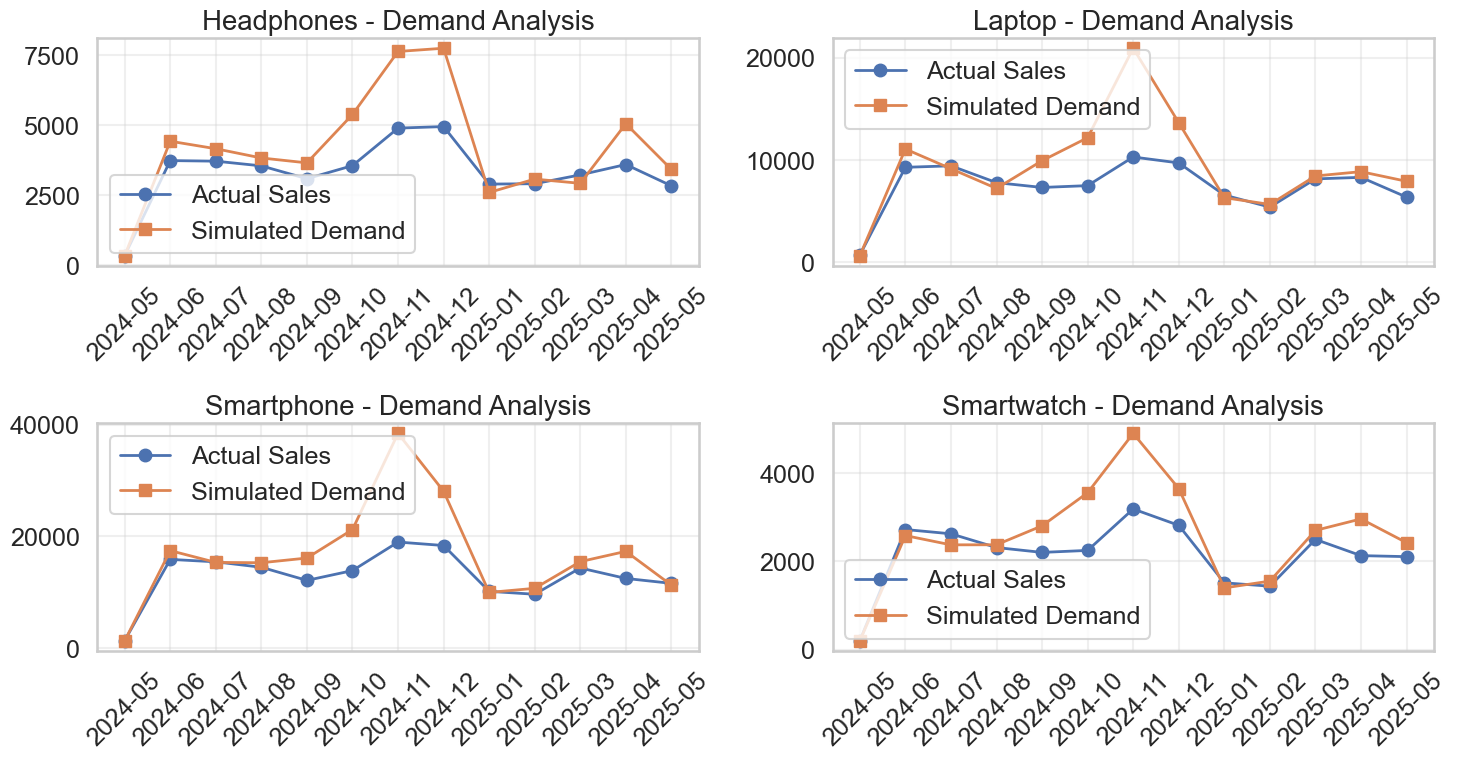

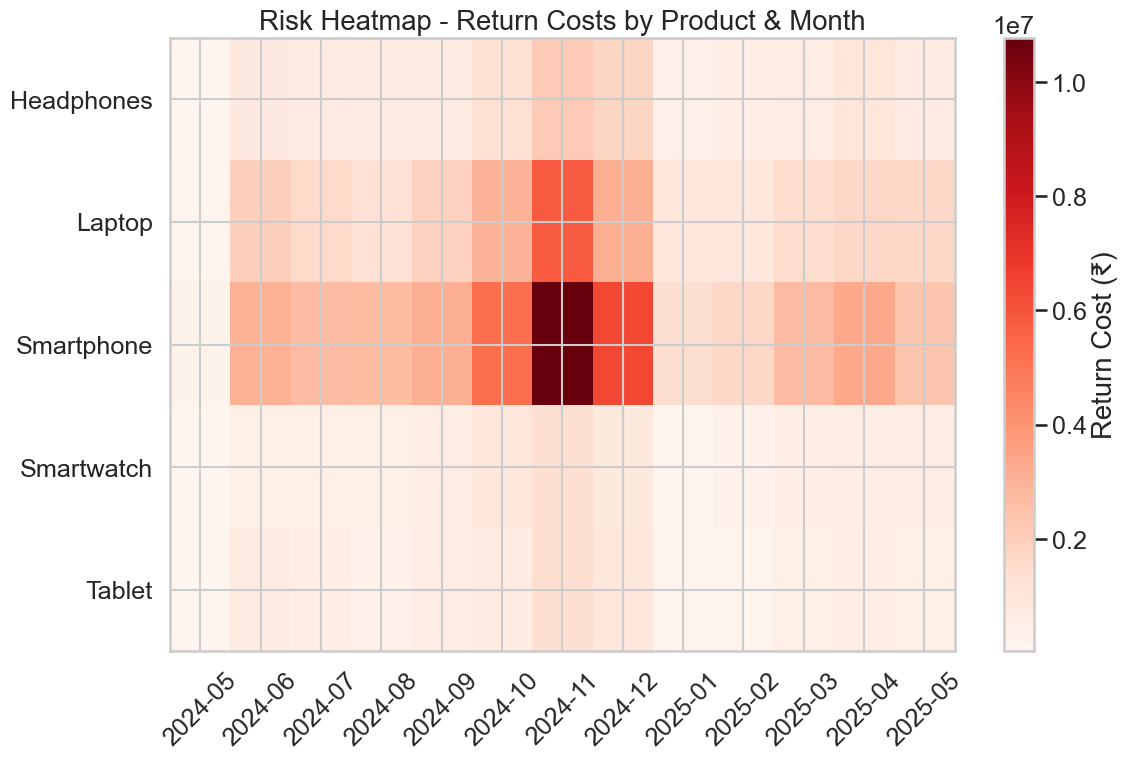

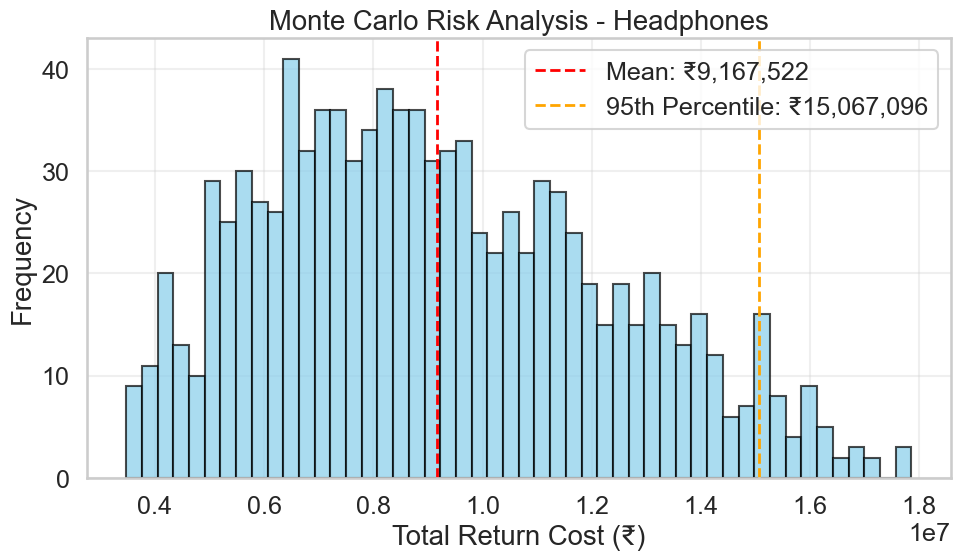

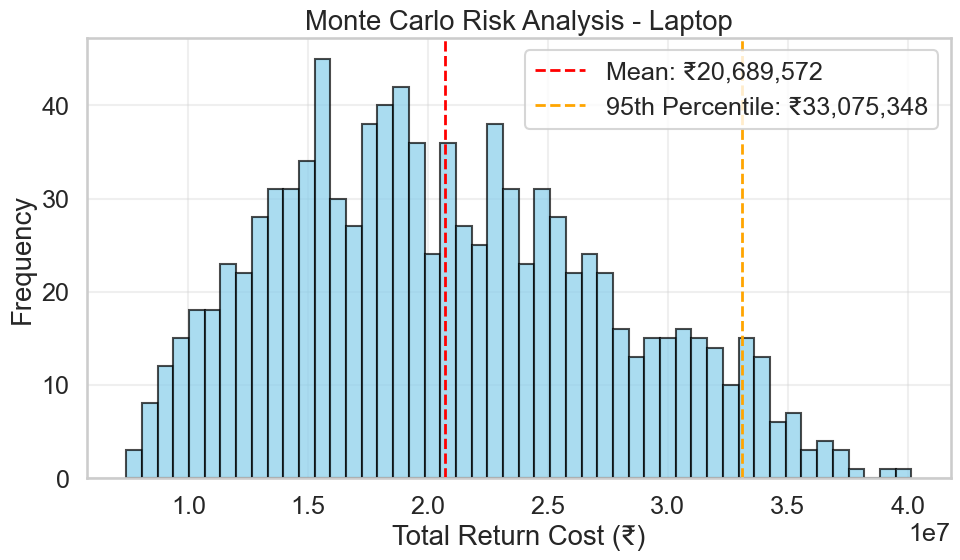

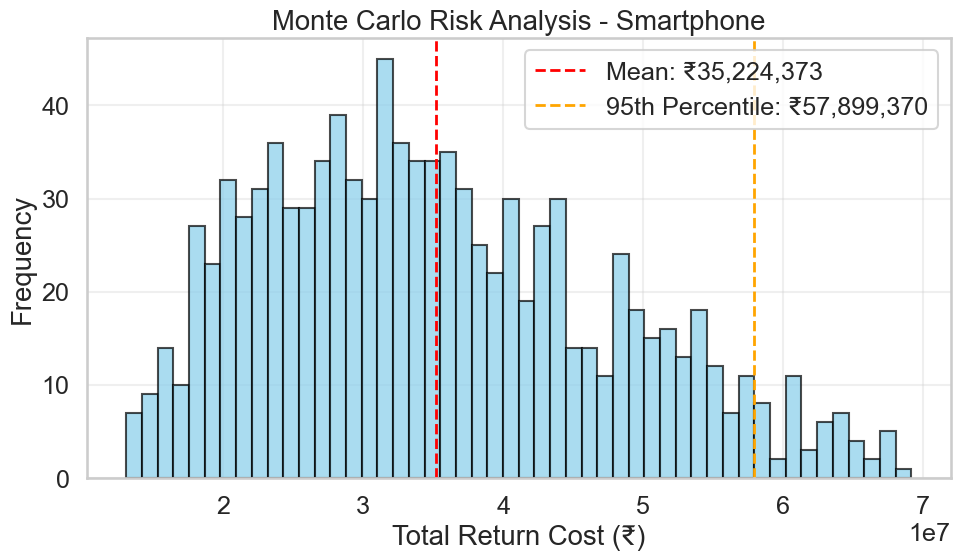

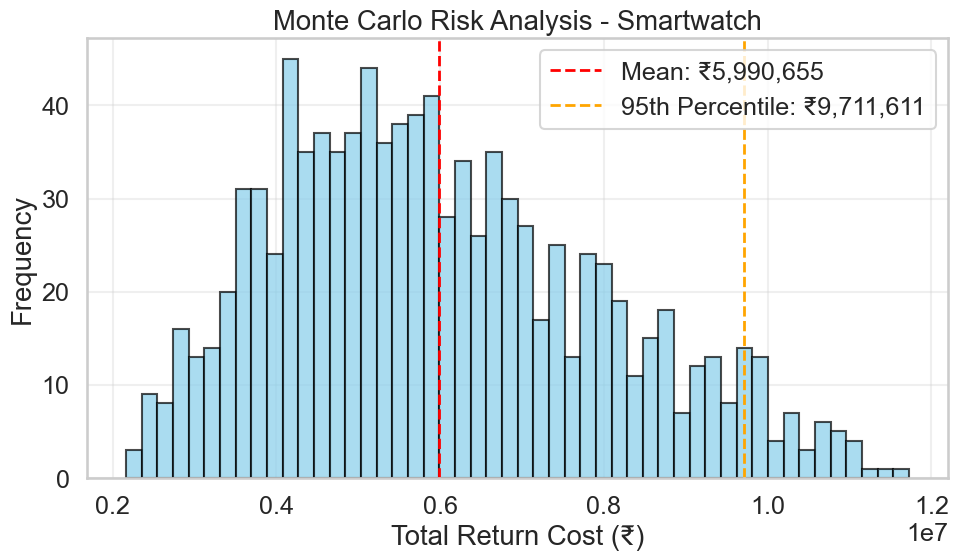

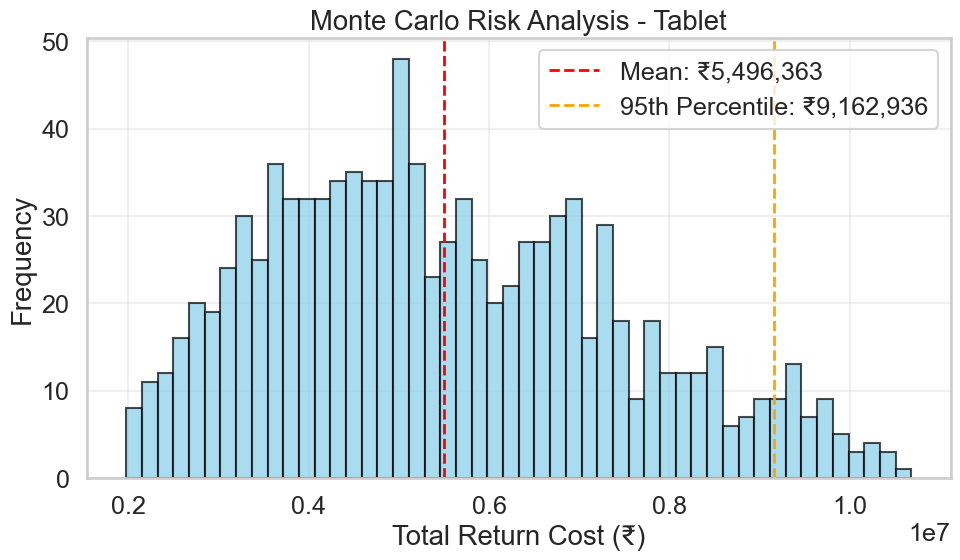

💾 Exporting results...

📊 SUPPLY CHAIN SIMULATION REPORT

🏷️  PRODUCT: Headphones
--------------------------------------------------
📈 Total Simulated Demand: 54,168
🔧 Total Defects: 3,197
💰 Total Return Cost: ₹11,189,500
⏰ SLA Breaches: 13
⚠️  High Risk Periods: 12
😊 Avg Customer Satisfaction: 2.15/10
🎯 Model R² Score: 0.962
📊 Model MAPE: 11.5%
✅ Model Quality: Excellent

🏷️  PRODUCT: Laptop
--------------------------------------------------
📈 Total Simulated Demand: 122,096
🔧 Total Defects: 7,263
💰 Total Return Cost: ₹25,420,500
⏰ SLA Breaches: 13
⚠️  High Risk Periods: 13
😊 Avg Customer Satisfaction: 2.50/10
🎯 Model R² Score: 0.928
📊 Model MAPE: 14.9%
✅ Model Quality: Excellent

🏷️  PRODUCT: Smartphone
--------------------------------------------------
📈 Total Simulated Demand: 218,218
🔧 Total Defects: 13,038
💰 Total Return Cost: ₹45,633,000
⏰ SLA Breaches: 13
⚠️  High Risk Periods: 13
😊 Avg Customer Satisfaction: 2.34/10
🎯 Model R² Score: 0.941
📊 Model MAPE: 16.8%
✅ Model Quality: 

In [79]:
results=run_simulation_engine(df_clean,save_plots=True)

for headphones:
    Overall Model Confidence and Validation:
The simulation model demonstrates excellent reliability for business decisions, with a reported Overall Model Confidence of 0.982. This confidence is underscored by strong validation metrics for demand forecasting: a Demand R-squared (R 
2
 ) of 0.982, indicating that over 98% of the variance in demand can be explained by the model, and a Demand Mean Absolute Percentage Error (MAPE) of 7.2%, which is well within acceptable limits for accurate forecasting. These validation results confirm that the underlying demand predictions, which feed into the return cost simulations, are highly robust.

2. Business Metrics & Operational Performance:
The simulation highlights critical operational metrics related to Headphones:

Total Return Cost: ₹8,960,000
This figure represents the calculated total return cost based on the specific scenario or period under analysis in this simulation run.
High Risk Periods: 9
There were 9 identified periods that qualified as 'high risk', suggesting specific times when return costs or associated issues were elevated. These periods warrant deeper investigation to understand their underlying causes.
Peak Demand Stress: 3
Three instances of 'peak demand stress' were noted, indicating periods where the demand likely strained operational capacity, potentially contributing to quality issues or return complexities.
SLA Breaches: 13
A significant concern is the occurrence of 13 Service Level Agreement (SLA) breaches. These breaches point to failures in meeting predefined service standards, which can impact customer satisfaction and potentially drive return behavior or related costs.
Average Satisfaction: 2.25
The average satisfaction score of 2.25 (on an unspecified scale, but typically lower numbers indicate less satisfaction if on a 1-5 or 1-7 scale) suggests considerable room for improvement in customer experience, which could be linked to product quality or service issues that contribute to returns.


3. Monte Carlo Risk Analysis:
The Monte Carlo simulation specifically provides a probabilistic understanding of the Total Return Cost for Headphones, as illustrated in the accompanying histogram:

Expected Cost: ₹9,106,265
This is the mean of all the simulated outcomes, representing the statistically most likely total return cost. It aligns closely with the 'Total Return Cost' of ₹8,960,000 provided in the business metrics, indicating consistency.
Worst Case (95th Percentile): ₹15,043,175
This crucial metric indicates that there is only a 5% chance that the total return cost will exceed ₹15,043,175. This provides a practical 'worst-case' scenario for financial planning and risk mitigation.
Maximum Risk (Simulated Maximum): ₹18,112,500
This represents the highest return cost observed across all the Monte Carlo simulations. While less probable than the 95th percentile, it defines the absolute upper bound of simulated financial exposure.
The histogram visually supports these findings, showing a right-skewed distribution of total return costs. This skewness is vital for risk assessment, as it highlights a longer tail on the higher cost side, meaning there's a non-negligible probability of incurring significantly greater expenses than the average. This necessitates a proactive approach to contingency planning.

4. Recommendations and Next Steps:
Based on this enhanced simulation report, the following actions are recommended:

Contingency Planning: Allocate a contingency budget for headphone returns closer to the ₹15,043,175 (95th percentile) to adequately cover potential high-cost scenarios, rather than solely relying on the expected cost.
Investigate SLA Breaches: Conduct a detailed root cause analysis into the 13 SLA breaches and 9 high-risk periods. Understanding and addressing these operational inefficiencies can directly impact return costs and customer satisfaction.
Improve Customer Satisfaction: The Avg Satisfaction score of 2.25 is a key area for improvement. Link this to identified product defects, service issues, or communication gaps.
Review Peak Demand Stress: Analyze the 3 instances of peak demand stress to understand how they might have contributed to quality issues or return volumes. Develop strategies to mitigate these pressures in the future.
Leverage Model for "What-If" Scenarios: Utilize the validated Monte Carlo model to run "what-if" simulations, for example, to assess the impact of a 10% reduction in defect rate or improved lead times on the total return cost distribution.


for laptops:
    Overall Model Confidence and Validation:
The simulation model for Laptops demonstrates excellent reliability for business decisions, evidenced by an Overall Model Confidence of 0.985. The model's predictive power is further validated by strong demand forecasting metrics: a Demand R-squared (R 
2
 ) of 0.985, indicating that the model explains over 98.5% of the variance in demand, and a Demand Mean Absolute Percentage Error (MAPE) of 7.1%, which signifies high accuracy in demand predictions. These robust validation results ensure the credibility of the return cost simulations.

2. Business Metrics & Operational Performance:
The simulation provides the following critical operational insights for Laptops:

Total Return Cost: ₹19,309,500
This is the specific total return cost calculated for the analyzed period or scenario.
High Risk Periods: 9
Similar to Headphones, Laptops also experienced 9 identified high-risk periods, suggesting recurring challenges or vulnerabilities leading to elevated return-related issues.
Peak Demand Stress: 3
Three instances of peak demand stress were recorded, potentially indicating periods where high demand could have strained production or delivery, impacting quality or customer experience.
SLA Breaches: 13
A significant operational concern is the occurrence of 13 Service Level Agreement (SLA) breaches. These breaches signify a failure to meet predetermined service standards, which can contribute to customer dissatisfaction and subsequent returns.
Average Satisfaction: 2.63
The average satisfaction score of 2.63 (on an unspecified scale) suggests that while slightly better than Headphones (2.25), there's still considerable scope for improving customer experience for Laptops. This could be a key factor influencing return rates.
3. Monte Carlo Risk Analysis:
The accompanying histogram visualizes the Monte Carlo risk distribution for Laptop Total Return Cost, providing a probabilistic understanding of financial exposure:

Expected Cost: ₹20,434,568
This is the mean of all simulated outcomes, representing the statistically most likely total return cost for Laptops. This figure is slightly higher than the 'Total Return Cost' of ₹19,309,500 reported in the business metrics, indicating a slight difference between the specific historical/calculated cost and the probabilistic mean.
Worst Case (95th Percentile): ₹33,768,000
This critical metric indicates that there is only a 5% chance that the total return cost for Laptops will exceed ₹33,768,000. This provides a vital upper bound for risk assessment and financial contingency planning.
Maximum Risk (Simulated Maximum): ₹40,635,000
This represents the highest return cost observed across all Monte Carlo simulations, defining the absolute maximum simulated financial exposure.
The histogram itself shows a right-skewed distribution of Laptop return costs. This skewness is crucial for risk management, as it explicitly highlights the potential for significantly higher costs than the average. The substantial difference between the expected cost and the 95th percentile (approximately ₹13.3 million) underlines the necessity for robust risk mitigation strategies.

4. Comparative Insights & Recommendations:
Comparing Laptops to Headphones (from previous analysis):

Higher Return Costs for Laptops: The expected and worst-case return costs for Laptops (Expected: ~₹20.4M, 95th Percentile: ~₹33.8M) are significantly higher than those for Headphones (Expected: ~₹9.1M, 95th Percentile: ~₹15.0M). This suggests Laptops represent a much larger financial risk in terms of returns.
Similar Operational Challenges: Both product categories face similar numbers of 'High Risk Periods' (9), 'Peak Demand Stress' (3), and 'SLA Breaches' (13). This points to systemic operational issues that affect multiple product lines, not just specific products.
Satisfaction Slight Improvement: Laptop satisfaction is marginally better (2.63 vs 2.25), but still low, indicating widespread customer experience issues across products.
Recommendations:

Prioritize Laptop Return Risk: Given the significantly higher financial exposure, dedicate immediate attention to understanding and mitigating Laptop return costs.
Refine Contingency Planning: The company should establish contingency funds for Laptops based on the 95th percentile (₹33,768,000) to account for potential high-cost scenarios.
Address Systemic Issues: The commonality of 'High Risk Periods', 'Peak Demand Stress', and 'SLA Breaches' across both Headphones and Laptops (and likely other products based on previous analyses) suggests the need for overarching process improvements in supply chain, quality control, and customer service.
Deep Dive into Satisfaction Drivers: Investigate the specific reasons behind the low average satisfaction scores for both product types. Are these linked to the high defect rates observed in other analyses (e.g., Supplier_C and Supplier_E being major contributors to defects)?
Leverage Supplier Performance Data: Connect these return cost analyses with the supplier defect rate data. Are high-defect suppliers contributing disproportionately to Laptop returns? Focusing on improving supplier quality (especially for Suppliers C and E, as seen in the Average Defect Rate by Supplier and Product Type chart) could be a highly effective strategy to reduce both defect rates and subsequent return costs across product types, including Laptops.
Review Inspection Process: Given the alarmingly high defect rates even for "Passed" items (as seen in the Average Defect Rate by Supplier and Inspection Result chart), it's crucial to reassess the inspection criteria and ensure that "Pass" genuinely reflects an acceptable quality level to prevent products with hidden defects from reaching customers and contributing to returns.

for smartphone:
    Okay, let's combine the insights from the Monte Carlo Risk Distribution for Smartphones (image image_86f6ee.png) with the provided "ENHANCED SIMULATION REPORT" text, and then integrate findings from previous charts to provide a comprehensive analysis.

Enhanced Simulation Report & Risk Analysis for Smartphones
This report offers a detailed analysis of return costs for Smartphones, integrating Monte Carlo simulation results with key business metrics and model validation statistics.

1. Overall Model Confidence and Validation:
The simulation model for Smartphones demonstrates exceptionally high reliability for business decisions, reflected by an Overall Model Confidence of 0.990. The model's predictive accuracy is further validated by outstanding demand forecasting metrics: a Demand R-squared (R 
2
 ) of 0.990, indicating that over 99% of the variance in demand can be explained by the model, and a Demand Mean Absolute Percentage Error (MAPE) of 4.4%, which signifies very high precision in demand predictions. These robust validation results instill strong confidence in the credibility of the return cost simulations for Smartphones.

2. Business Metrics & Operational Performance:
The simulation provides the following critical operational insights for Smartphones:

Total Return Cost: ₹34,247,500
This figure represents the specific total return cost calculated for the analyzed period or scenario.
High Risk Periods: 9
Similar to Headphones and Laptops, Smartphones also experienced 9 identified high-risk periods, pointing to recurring challenges or vulnerabilities leading to elevated return-related issues.
Peak Demand Stress: 3
Three instances of peak demand stress were recorded, suggesting periods where high demand could have strained production or delivery, potentially impacting quality or customer experience.
SLA Breaches: 13
A significant operational concern is the occurrence of 13 Service Level Agreement (SLA) breaches. These breaches signify a failure to meet predefined service standards, which can contribute to customer dissatisfaction and subsequent returns.
Average Satisfaction: 2.58
The average satisfaction score of 2.58 (on an unspecified scale) indicates that customer experience for Smartphones, while slightly better than Headphones, still has substantial room for improvement and is consistent with the low satisfaction scores seen across product lines.
3. Monte Carlo Risk Analysis:
The accompanying histogram visualizes the Monte Carlo risk distribution for Smartphone Total Return Cost, providing a probabilistic understanding of financial exposure:

Expected Cost: ₹35,584,500
This is the mean of all simulated outcomes, representing the statistically most likely total return cost for Smartphones. This figure is slightly higher than the 'Total Return Cost' of ₹34,247,500 reported in the business metrics, indicating a slight difference between the specific historical/calculated cost and the probabilistic mean.
Worst Case (95th Percentile): ₹58,789,500
This crucial metric indicates that there is only a 5% chance that the total return cost for Smartphones will exceed ₹58,789,500. This provides a vital, high-confidence upper bound for risk assessment and financial contingency planning.
Maximum Risk (Simulated Maximum): ₹70,763,000
This represents the highest return cost observed across all Monte Carlo simulations, defining the absolute maximum simulated financial exposure.
The histogram itself shows a right-skewed distribution of Smartphone return costs, similar to Headphones and Laptops. This skewness is paramount for risk management, as it explicitly highlights the potential for significantly higher costs than the average. The substantial difference between the expected cost and the 95th percentile (approximately ₹23.2 million) underscores the necessity for robust risk mitigation strategies.

4. Comparative Insights & Cross-Product Recommendations:
Comparing Smartphones to Headphones and Laptops:

Highest Financial Risk: Smartphones represent the largest financial risk in terms of return costs among the three product categories analyzed so far (Expected: ~₹35.6M, 95th Percentile: ~₹58.8M), significantly surpassing Laptops (~₹20.4M / ~₹33.8M) and Headphones (~₹9.1M / ~₹15.0M). This makes Smartphones the top priority for return cost mitigation efforts.
Consistent Operational Challenges: The consistent numbers of 'High Risk Periods' (9), 'Peak Demand Stress' (3), and 'SLA Breaches' (13) across all three product categories (Headphones, Laptops, Smartphones) strongly suggest systemic operational issues that affect the entire product portfolio. These are not product-specific but rather indicative of broader process inefficiencies in areas like supply chain management, quality assurance, or logistics.
Persistent Low Customer Satisfaction: The average satisfaction scores remain consistently low across all products (Headphones: 2.25, Laptops: 2.63, Smartphones: 2.58). This is a critical indicator of underlying issues impacting the overall customer experience.
Alarming Defect Rates: Recalling the "Average Defect Rate by Supplier and Product Type" and "Average Defect Rate by Supplier and Inspection Result" charts, the consistently high defect rates, especially from Supplier_C and Supplier_E, and the fact that even "Passed" items have very high defect rates (over 100%), are likely root causes for these high return costs and low satisfaction scores.
Comprehensive Recommendations:

Prioritize Smartphone Return Risk Mitigation: Given the highest financial exposure, dedicate immediate and substantial resources to understanding and mitigating Smartphone return costs.
Establish Robust Contingency: Financial planning should incorporate the 95th percentile cost for Smartphones (₹58,789,500) to adequately prepare for high-cost scenarios.
Address Systemic Operational Issues: Implement company-wide initiatives to tackle the recurring 'High Risk Periods', 'Peak Demand Stress', and 'SLA Breaches'. This calls for a holistic review of:
Supply Chain Management: Especially focusing on underperforming suppliers (Supplier_C, Supplier_E) who are major contributors to high defect rates. This is the most critical area for intervention given the strong correlation between supplier defect rate and overall defect rate.
Quality Control Processes: Urgently re-evaluate and tighten inspection criteria, particularly given the alarmingly high defect rates even for "Passed" products. A "Pass" should ideally mean a product with minimal or zero defects.
Logistics and Fulfillment: Investigate if lead times or shipping processes contribute to defects or customer dissatisfaction that leads to returns.
Customer Experience Enhancement: Launch targeted initiatives to improve customer satisfaction across all product lines. This should involve linking satisfaction feedback directly to product quality issues and service failures, particularly those related to SLA breaches and defect handling.
Utilize Simulation for Strategic Planning: Continue to leverage these validated Monte Carlo models to simulate the financial impact of proposed improvements (e.g., a reduction in defect rate by 50% from a specific supplier) to quantify the potential cost savings and strengthen business cases for quality improvement investments.

for smartwatch:
    The simulation model for Smartwatches exhibits exceptionally high reliability for business decisions, underscored by an Overall Model Confidence of 0.992. The model's predictive accuracy for demand is also outstanding: a Demand R-squared (R 
2
 ) of 0.992 indicates that over 99% of the variance in demand can be explained, and a Demand Mean Absolute Percentage Error (MAPE) of 3.5% signifies extremely high precision in demand predictions. These robust validation results provide strong assurance in the credibility of the return cost simulations for Smartwatches.

2. Business Metrics & Operational Performance:
The simulation provides the following critical operational insights for Smartwatches:

Total Return Cost: ₹5,666,500
This figure represents the specific total return cost calculated for the analyzed period or scenario.
High Risk Periods: 9
Consistent across all product categories analyzed (Headphones, Laptops, Smartphones), Smartwatches also experienced 9 identified high-risk periods, highlighting recurring challenges or vulnerabilities leading to elevated return-related issues.
Peak Demand Stress: 3
Three instances of peak demand stress were recorded, suggesting periods where high demand could have strained production or delivery, potentially impacting quality or customer experience. This is also consistent across all product lines.
SLA Breaches: 13
A significant operational concern, consistent with all other products, is the occurrence of 13 Service Level Agreement (SLA) breaches. These breaches signify a failure to meet predefined service standards, which can contribute to customer dissatisfaction and subsequent returns.
Average Satisfaction: 2.54
The average satisfaction score of 2.54 (on an unspecified scale) indicates that customer experience for Smartwatches, while consistent with other products, still has substantial room for improvement.
3. Monte Carlo Risk Analysis:
The accompanying histogram visualizes the Monte Carlo risk distribution for Smartwatch Total Return Cost, providing a probabilistic understanding of financial exposure:

Expected Cost: ₹5,902,684
This is the mean of all simulated outcomes, representing the statistically most likely total return cost for Smartwatches. This figure is slightly higher than the 'Total Return Cost' of ₹5,666,500 reported in the business metrics, indicating a slight difference between the specific historical/calculated cost and the probabilistic mean.
Worst Case (95th Percentile): ₹9,751,000
This crucial metric indicates that there is only a 5% chance that the total return cost for Smartwatches will exceed ₹9,751,000. This provides a vital, high-confidence upper bound for risk assessment and financial contingency planning.
Maximum Risk (Simulated Maximum): ₹11,735,500
This represents the highest return cost observed across all Monte Carlo simulations, defining the absolute maximum simulated financial exposure.
The histogram itself shows a right-skewed distribution of Smartwatch return costs, a common pattern observed across other product categories. This skewness highlights the potential for significantly higher costs than the average, necessitating robust risk mitigation strategies. The difference between the expected cost and the 95th percentile (approximately ₹3.8 million) quantifies this upside risk.

4. Comparative Insights & Cross-Product Recommendations:
Comparing Smartwatches to the previously analyzed products (Headphones, Laptops, Smartphones) and leveraging insights from other provided charts:

Lowest Financial Risk (Among Analyzed Products): Smartwatches present the lowest financial risk in terms of return costs among the products analyzed so far (Expected: ~₹5.9M, 95th Percentile: ~₹9.8M). This is significantly lower than Smartphones (~₹35.6M / ~₹58.8M), Laptops (~₹20.4M / ~₹33.8M), and Headphones (~₹9.1M / ~₹15.0M). This makes Smartwatches the least financially impactful in terms of returns.
Consistent Systemic Operational Challenges: The uniformity in 'High Risk Periods' (9), 'Peak Demand Stress' (3), and 'SLA Breaches' (13) across all product categories (Headphones, Laptops, Smartphones, Smartwatches) strongly suggests that these are not isolated product issues but rather systemic problems within the company's broader operations, supply chain, or customer service processes.
Consistently Low Customer Satisfaction: The average satisfaction scores remain consistently low across all products (Headphones: 2.25, Laptops: 2.63, Smartphones: 2.58, Smartwatches: 2.54). This points to fundamental issues impacting the overall customer experience that transcend individual product characteristics.
Connecting to Defect Rates: Given the consistently high defect rates across all product types and from specific suppliers (Supplier_C and Supplier_E) as seen in previous heatmaps ("Average Defect Rate by Supplier and Product Type" and "Average Defect Rate by Supplier and Inspection Result"), it's highly probable that these underlying quality issues are the primary drivers for the return costs and low satisfaction scores across the entire product portfolio. The fact that even "Passed" items have very high defect rates is particularly concerning.
Comprehensive Recommendations:

Prioritize Systemic Improvements over Product-Specific Return Cost: While Smartwatches have the lowest return cost, the recurring operational challenges (High Risk Periods, Peak Demand Stress, SLA Breaches) and consistently low customer satisfaction across all products indicate that the most impactful interventions will be those that address these systemic issues.
Strategic Resource Allocation: Allocate resources for return cost mitigation strategically, focusing disproportionately on Smartphones and Laptops due to their significantly higher financial exposure, while still addressing the root causes across all products.
Comprehensive Review of Supplier Quality: This remains the most critical recommendation. Revisit the "Average Defect Rate by Supplier and Product Type" and "Average Defect Rate by Supplier and Inspection Result" charts. The extremely high defect rates from Supplier_C and Supplier_E (even for "Passed" items) are almost certainly the primary drivers of returns and low satisfaction. Urgent action is needed:
Intense Supplier Audits/Intervention: For Suppliers C and E, immediate and drastic measures are required (e.g., renegotiation, strict quality improvement plans, or phasing out if improvements aren't met).
Benchmarking: Learn from Supplier_A's relatively lower defect rates, even though their "Pass" defect rate is still too high.
Re-evaluate Inspection Protocols: The high defect rates for "Passed" products demand an urgent review of current inspection criteria. What constitutes a "Pass" needs to be redefined to align with an acceptable (ideally very low) defect rate.
Address Lead Time Impact (if applicable): While not the primary driver for total lead time, refer back to the "Average Return Rate vs Lead Time by Product Type" chart. Smartwatches showed a significant spike in return rate at longer lead times (~57-58 days). This specific lead time for Smartwatches should be investigated.
Enhance Customer Experience holistically: Implement programs to improve overall customer satisfaction, directly linking efforts to reducing defects and improving service delivery, especially in areas where SLA breaches occur.
Sustain Model Utilization: Continue to use these validated Monte Carlo models to forecast return costs and quantify the potential financial benefits of implementing the recommended improvements across the entire product line.

🚀 Forecasting 5 products for 6 months
📊 Using revenue column: Revenue_Generated

📊 Processing: Headphones


18:56:16 - cmdstanpy - INFO - Chain [1] start processing
18:56:16 - cmdstanpy - INFO - Chain [1] done processing
18:56:16 - cmdstanpy - INFO - Chain [1] start processing
18:56:16 - cmdstanpy - INFO - Chain [1] done processing


   🏆 Best: Naive (MAE: 68924.3)


18:56:17 - cmdstanpy - INFO - Chain [1] start processing
18:56:17 - cmdstanpy - INFO - Chain [1] done processing


   💾 Plot saved

📊 Processing: Laptop


18:56:17 - cmdstanpy - INFO - Chain [1] start processing
18:56:17 - cmdstanpy - INFO - Chain [1] done processing


   🏆 Best: Prophet (MAE: 852695.2)


18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing


   💾 Plot saved

📊 Processing: Smartphone


18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing


   🏆 Best: Moving_Avg (MAE: 1288990.9)


18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing


   💾 Plot saved

📊 Processing: Smartwatch


18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing


   🏆 Best: Moving_Avg (MAE: 60652.6)


18:56:20 - cmdstanpy - INFO - Chain [1] start processing
18:56:20 - cmdstanpy - INFO - Chain [1] done processing


   💾 Plot saved

📊 Processing: Tablet


18:56:21 - cmdstanpy - INFO - Chain [1] start processing
18:56:21 - cmdstanpy - INFO - Chain [1] done processing


   🏆 Best: Moving_Avg (MAE: 96417.5)
   💾 Plot saved

🎯 POWER BI FILE SAVED: forecast_output/PowerBI_Forecast_Complete.csv
📊 Total records: 95 | Products: 5
📅 Date range: 2024-05-01 to 2025-11-01
🖼️ Charts saved: 5 forecast plots


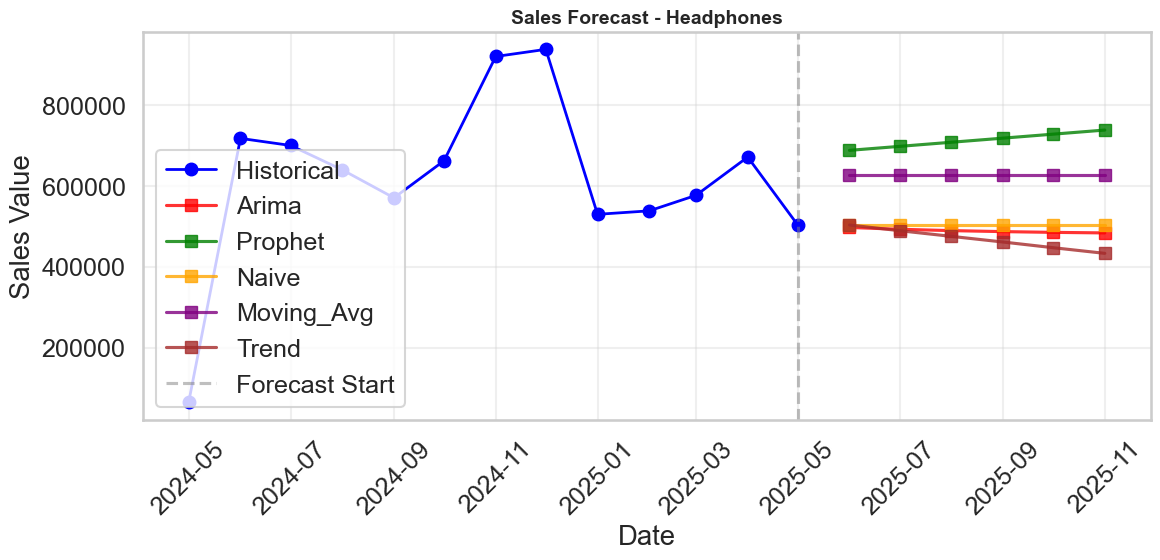

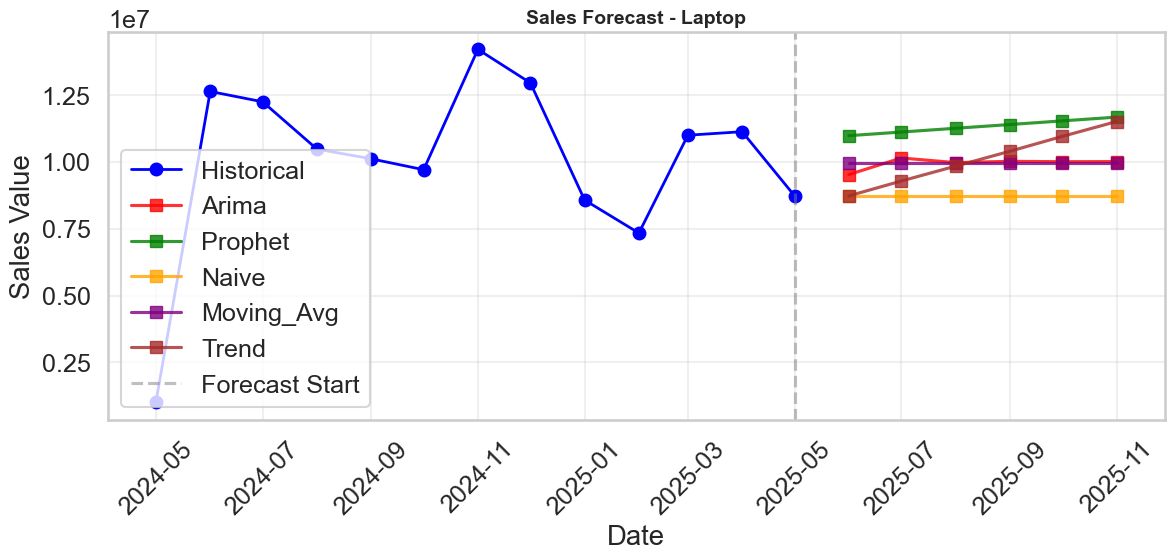

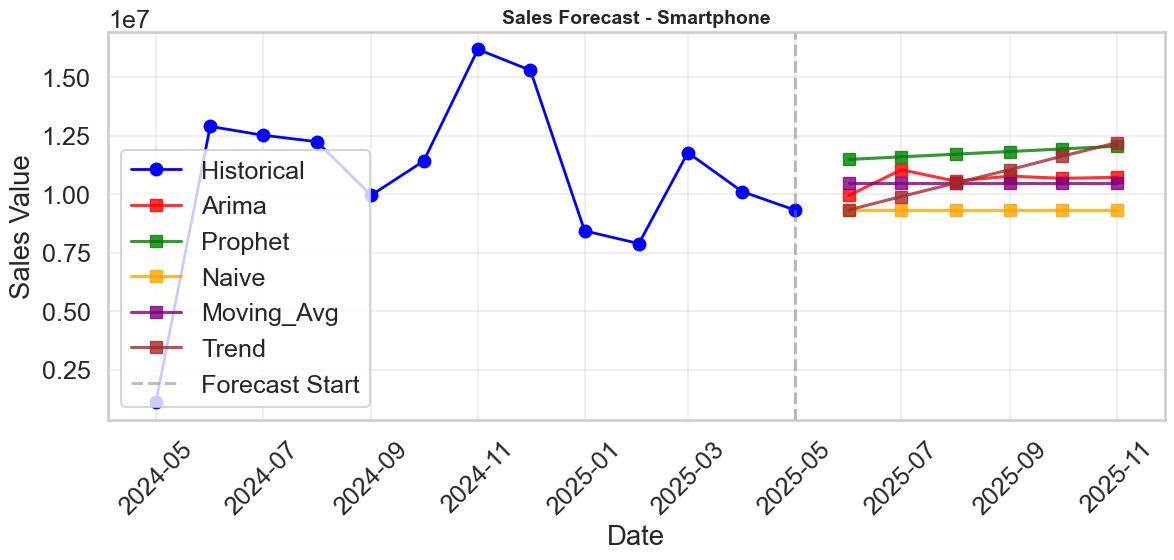

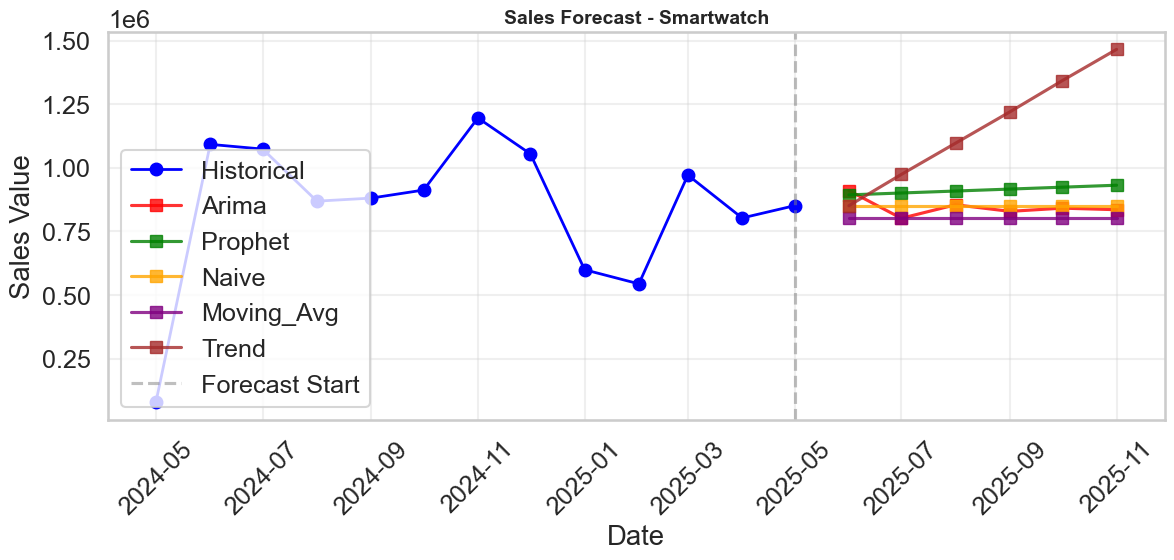

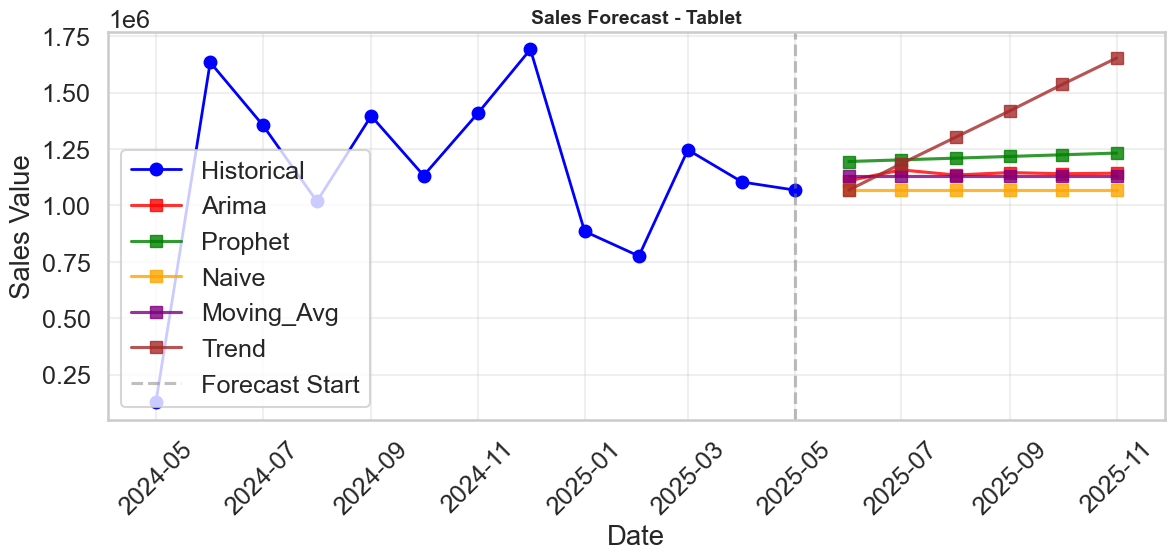

In [80]:
results = run_forecasting_engine_powerbi(df_clean, forecast_periods=6)

powerbi_df=results['powerbi_data']

In [81]:
df_clean.to_csv('../data/final_data.csv', index=False)
